In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import inspect
currentdir = os.path.dirname(os.path.abspath(
    inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
os.sys.path.insert(1, parentdir+'/src')
import torch
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
import time
from tqdm import trange
import matplotlib.pyplot as plt
import matplotlib

In [3]:
import gym
import pybullet as p
import stage.envs
from stage.tasks.twolink.reaching import TwoLinkReaching
from stage.utils.nn import use_gpu
use_gpu()

In [4]:
savepath = parentdir + '/data/twolink/'

In [5]:
task = TwoLinkReaching(render=False)

# Read task parameters, should we use a separate class to wrap this?

nq, nv, nu, nx = task.nq, task.nv, task.nu, task.nx
dt_control, dt_env = task.dt_control, task.dt_env
q_lb, q_ub = task.q_lb, task.q_ub
v_lb, v_ub = -100*torch.ones_like(q_lb), 100*torch.ones_like(q_ub)

In [6]:
task.env.set_state(np.zeros(2), np.zeros(2))
task.env.get_state()
pos, orn = p.getLinkState(0, 1, computeForwardKinematics=1)[:2]

In [7]:
from stage.utils.robotics import ForwardKinematics
from stage.tasks.twolink.params import JOINT_XYZ, JOINT_RPY, JOINT_AXIS, LINK_XYZ
fwk = ForwardKinematics(7, JOINT_XYZ, JOINT_RPY, JOINT_AXIS, LINK_XYZ)
q = torch.zeros(1,2)
link_world = fwk(q, 1)
link_pos = link_world[:, :3, 3]
print (link_pos)

tensor([[0.0000, 0.0000, 1.6250]])


In [8]:
# Setup action parameterization

from stage.controllers.actor import Actor
from stage.controllers.trivial import Identity
from stage.controllers.pd import PD

# na = 2
# action_ub = torch.Tensor(task.env.action_space.high)
# action_lb = torch.Tensor(task.env.action_space.low)
# actor = Actor(na, Identity(nq, nv, nu), action_lb, action_ub)

na = 4
gain_ub = 50 * torch.ones((nq))
gain_lb = 0. * torch.ones((nq))
action_ub = torch.cat((gain_ub, q_ub))
action_lb = torch.cat((gain_lb, q_lb))
actor = Actor(PD(nx, nq, nv, nu), action_lb, action_ub)

task.cost.actor = actor 

In [9]:
# # Setup model learning

from stage.dynamics.probabilistic_ensemble import ProbabilisticEnsemble, DefaultDx

ensemble_size = 5
nn_epochs = 10
batch_size = 64
    
dynamics = ProbabilisticEnsemble(nx, nq, nv, na, dt_control, 
                                 DefaultDx,
                                 ensemble_size,
                                 learning_rate = 0.001)

dynamics.state_lb = torch.cat((q_lb, v_lb))
dynamics.state_ub = torch.cat((q_ub, v_ub))

In [10]:
# Setup controller

from stage.controllers.pets import PETS

plan_horizon = 30
n_particles = 10
pop_size = 400

controller = PETS(dynamics, task.cost, actor,
                  plan_horizon, n_particles, pop_size)

In [11]:
# Setup learner

from stage.learners.learn_and_control_model import LearnAndControlModel
learner = LearnAndControlModel(task, dynamics, controller)

In [12]:
controller.regularize(1)
_ = learner.learn(20, verbose=True)
learner.save_training_data(savepath+'data_pd_regg')

Network training: 100%|██████████| 10/10 [00:00<00:00, 32.96epoch(s)/s, Training loss MSE=2.1783633]


Iteration:  0
Initial state:  tensor([1.5708, 0.0000, 0.0000, 0.0000])
avg. decision time:  0.011166918277740478
obs. reward:  -294.39392
act. reward:  -1.6025623


Network training: 100%|██████████| 10/10 [00:00<00:00, 11.71epoch(s)/s, Training loss MSE=0.58870393]


Iteration:  1
Initial state:  tensor([1.5708, 0.0000, 0.0000, 0.0000])
avg. decision time:  0.3081105446815491
obs. reward:  -143.88504
act. reward:  -0.40439266


Network training: 100%|██████████| 10/10 [00:01<00:00,  8.37epoch(s)/s, Training loss MSE=0.32904592]


Iteration:  2
Initial state:  tensor([1.5708, 0.0000, 0.0000, 0.0000])
avg. decision time:  0.3093672204017639
obs. reward:  -204.70003
act. reward:  -0.5531603


Network training: 100%|██████████| 10/10 [00:01<00:00,  6.46epoch(s)/s, Training loss MSE=0.26820502]


Iteration:  3
Initial state:  tensor([1.5708, 0.0000, 0.0000, 0.0000])
avg. decision time:  0.3100024962425232
obs. reward:  -126.37808
act. reward:  -0.21419744


Network training: 100%|██████████| 10/10 [00:01<00:00,  5.21epoch(s)/s, Training loss MSE=0.1992305]


Iteration:  4
Initial state:  tensor([1.5708, 0.0000, 0.0000, 0.0000])
avg. decision time:  0.3124005103111267
obs. reward:  -94.17991
act. reward:  -0.45836467


Network training: 100%|██████████| 10/10 [00:02<00:00,  4.36epoch(s)/s, Training loss MSE=0.21513176]


Iteration:  5
Initial state:  tensor([1.5708, 0.0000, 0.0000, 0.0000])
avg. decision time:  0.3117906665802002
obs. reward:  -658.85864
act. reward:  -0.36123973


Network training: 100%|██████████| 10/10 [00:02<00:00,  3.79epoch(s)/s, Training loss MSE=0.30366734]


Iteration:  6
Initial state:  tensor([1.5708, 0.0000, 0.0000, 0.0000])
avg. decision time:  0.31400667190551756
obs. reward:  -308.3884
act. reward:  -4.1916757


Network training: 100%|██████████| 10/10 [00:02<00:00,  3.35epoch(s)/s, Training loss MSE=0.31966802]


Iteration:  7
Initial state:  tensor([1.5708, 0.0000, 0.0000, 0.0000])
avg. decision time:  0.31480979681015014
obs. reward:  -677.6009
act. reward:  -0.35177377


Network training: 100%|██████████| 10/10 [00:03<00:00,  2.91epoch(s)/s, Training loss MSE=0.27268004]


Iteration:  8
Initial state:  tensor([1.5708, 0.0000, 0.0000, 0.0000])
avg. decision time:  0.3136217451095581
obs. reward:  -833.912
act. reward:  -0.6279248


Network training: 100%|██████████| 10/10 [00:03<00:00,  2.66epoch(s)/s, Training loss MSE=0.26551795]


Iteration:  9
Initial state:  tensor([1.5708, 0.0000, 0.0000, 0.0000])
avg. decision time:  0.31297733783721926
obs. reward:  -636.0283
act. reward:  -0.37485504


Network training: 100%|██████████| 10/10 [00:04<00:00,  2.43epoch(s)/s, Training loss MSE=0.25141206]


Iteration:  10
Initial state:  tensor([1.5708, 0.0000, 0.0000, 0.0000])
avg. decision time:  0.31280270099639895
obs. reward:  -648.3319
act. reward:  -0.26400045


Network training: 100%|██████████| 10/10 [00:04<00:00,  2.27epoch(s)/s, Training loss MSE=0.22412053]


Iteration:  11
Initial state:  tensor([1.5708, 0.0000, 0.0000, 0.0000])
avg. decision time:  0.32507713079452516
obs. reward:  -634.6888
act. reward:  -0.21591672


Network training: 100%|██████████| 10/10 [00:04<00:00,  2.28epoch(s)/s, Training loss MSE=0.22514614]


Iteration:  12
Initial state:  tensor([1.5708, 0.0000, 0.0000, 0.0000])
avg. decision time:  0.31312016248703
obs. reward:  -597.19727
act. reward:  -0.8973842


Network training: 100%|██████████| 10/10 [00:05<00:00,  1.95epoch(s)/s, Training loss MSE=0.1876453]


Iteration:  13
Initial state:  tensor([1.5708, 0.0000, 0.0000, 0.0000])
avg. decision time:  0.3146109938621521
obs. reward:  -86.30761
act. reward:  -0.8717477


Network training: 100%|██████████| 10/10 [00:05<00:00,  1.81epoch(s)/s, Training loss MSE=0.20471719]


Iteration:  14
Initial state:  tensor([1.5708, 0.0000, 0.0000, 0.0000])
avg. decision time:  0.3136025094985962
obs. reward:  -111.8251
act. reward:  -1.0669951


Network training: 100%|██████████| 10/10 [00:05<00:00,  1.69epoch(s)/s, Training loss MSE=0.17765196]


Iteration:  15
Initial state:  tensor([1.5708, 0.0000, 0.0000, 0.0000])
avg. decision time:  0.3134151387214661
obs. reward:  -97.375404
act. reward:  -0.81479114


Network training: 100%|██████████| 10/10 [00:06<00:00,  1.57epoch(s)/s, Training loss MSE=0.1520783]


Iteration:  16
Initial state:  tensor([1.5708, 0.0000, 0.0000, 0.0000])
avg. decision time:  0.3131006336212158
obs. reward:  -71.85872
act. reward:  -0.85521984


Network training: 100%|██████████| 10/10 [00:06<00:00,  1.48epoch(s)/s, Training loss MSE=0.20959245]


Iteration:  17
Initial state:  tensor([1.5708, 0.0000, 0.0000, 0.0000])
avg. decision time:  0.3147567176818848
obs. reward:  -584.1083
act. reward:  -0.30308944


Network training: 100%|██████████| 10/10 [00:07<00:00,  1.42epoch(s)/s, Training loss MSE=0.14343685]


Iteration:  18
Initial state:  tensor([1.5708, 0.0000, 0.0000, 0.0000])
avg. decision time:  0.3140582251548767
obs. reward:  -66.997635
act. reward:  -1.0176477


Network training: 100%|██████████| 10/10 [00:07<00:00,  1.34epoch(s)/s, Training loss MSE=0.1368374]

Iteration:  19
Initial state:  tensor([1.5708, 0.0000, 0.0000, 0.0000])
avg. decision time:  0.3134388732910156
obs. reward:  -69.19463
act. reward:  -1.2960072


In [13]:
controller.regularize(1)
traj, log = task.perform(task.goal, controller)
act_seq = traj[:, nx:nx+na]
initial_obs = traj[0, :nx]
final_obs = traj[-1, :nx]

avg. decision time:  0.3145702314376831
obs. reward:  -77.88807
act. reward:  -0.7772488


In [14]:
n_sample = 50
traj_pred = dynamics.unroll(initial_obs, 
                            act_seq, 
                            n_sample)

predicted_err = torch.norm(traj_pred[-1, :, :]-final_obs.expand(n_sample, -1), p=2, dim=1)
print (predicted_err.mean())
print (predicted_err.std())

tensor(1.0250, grad_fn=<MeanBackward0>)
tensor(1.1729, grad_fn=<StdBackward0>)


In [15]:
task_horizon = task.task_horizon

traj_pred_mean = torch.mean(traj_pred, dim=1)
traj_pred_std = torch.std(traj_pred, dim=1)
traj_pred_mean = traj_pred_mean.detach().cpu().numpy()
traj_pred_std = traj_pred_std.detach().cpu().numpy()
traj = traj.detach().cpu().numpy()

desired = task.cost.desired.repeat((task_horizon, 1))
desired = desired.detach().cpu().numpy()

In [16]:
font = {'family' : 'serif',
        'size'   : 22}

matplotlib.rc('font', **font)
np.set_printoptions(precision=3, linewidth=200, suppress=True)

In [17]:
# traj_pred_mean = np.load('traj_pred_mean.npy')
# traj_pred_std = np.load('traj_pred_std.npy')
# traj = np.load('traj.npy')

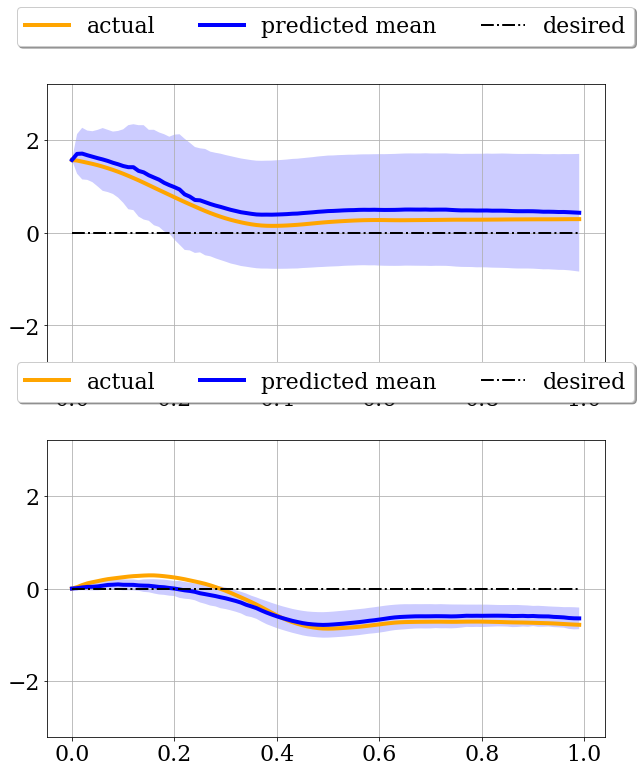

In [18]:
d = nq
dt = dt_control
fig, ax = plt.subplots(d, figsize=(10, d * 6))
t = np.arange(0.0, task_horizon*dt, dt)
dlb = traj_pred_mean - traj_pred_std
ub = traj_pred_mean + traj_pred_std

for i in range(d):
    ax[i].plot(t, traj[:, i], lw=4, color='orange', label='actual')
    ax[i].plot(t, traj_pred_mean[:, i], lw=4, color='b', label='predicted mean')
    ax[i].plot(t, desired[:, i], lw=2, color='k', ls='-.', label='desired')
    lb = traj_pred_mean - traj_pred_std
    ub = traj_pred_mean + traj_pred_std
    ax[i].fill_between(t, lb[:, i], ub[:, i], facecolor='blue',
                alpha=0.2)
    _ = ax[i].grid()
    _ = ax[i].set_ylim([-3.2, 3.2])
    ax[i].legend(loc='upper center', bbox_to_anchor=(0.5, 1.3),
             ncol=3, fancybox=True, shadow=True)
# fig.savefig('prediction_with_reg_150steps' + '.png', bbox_inches='tight')

In [19]:
# import numpy as np
# from stage.tasks.twolink.reaching import TwoLinkReaching
# from stage.utils.nn import use_gpu
# use_gpu()
# savepath = parentdir + '/data/twolink/'
# data_train = np.load(savepath+'data_pd_reg.npy')
# task = TwoLinkReaching(render=True)
# task.visualize_training_data(data_train, 0)